# Práctica 3 - Ajuste de Modelos Lineales

### Alumno: MIGUEL GARCÍA LÓPEZ
### Grupo: A2

Límite de entrega: 5 de Junio de 2022 a las 23:59 (PRADO)

Valoración máxima: 12 puntos

#**1 -- (CLASIFICACIÓN) --** 

#Análisis del problema
Este conjuntos de datos recoge información sobre campañas de marketing de un una institución bancaria Portuguesa. Estas se basan en llamadas de teléfono a los clientes, y muchas de esas veces se requiere más de una llamada para el mismo cliente.

Se nos ofrecen tres archivos:
* bank-names.txt -> un fichero con la descripción del problema e información relevante.
* bank-full.csv -> un fichero con todos los datos de nuestro problema.
* bank.csv -> un fichero con un 10% de ejemplos seleccionados sobre el total y completamente aleatorios. Se podrían utilizar como partición test (en nuestro caso lo haremos nosotros mismos).

Nosotros vamos a utilizar el archivo "bank-full.csv" que contiene todos los ejemplos. A la hora de hacer las particiones test y training, las haremos nosotros mismos.

* X -> Los inputs de nuestro problema son los clientes, los cuales tiene una serie de características a tener en cuenta:
  * x = [edad, trabajo estado civil, educación, crédito en mora, balance, hipoteca, préstamo, tipo de contacto, último día de contacto, último mes de contacto, duración del contacto, número de contactos al cliente durante la campaña, número de día desde que el cliente fue contactado desde la última campaña, número de contactos realizados antes de esta campaña al cliente, resultado de la campaña anterior]
* Y -> Los outputs esperados de nuestro problema, las etiquetas deseadas:
  * y = [sí, no] (si el cliente ha suscrito un depósito a plazo)
* F -> la función objetivo de nuestro problema sería una que dado unos datos X nos devolviera unas salidas Y con predicciones perfectas sobre si el cliente va a suscribirse a un depósito a plazo.

In [1]:
# Librerías a utilizar
import pandas as pd
import math as mt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from numpy import nan
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import linear_model
from sklearn import metrics
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Clasificación
path = '/content/drive/My Drive/Colab Notebooks/datos3/clas/bank-full.csv'
 
# Función para lectura de datos
def readData(path):
  data = pd.read_csv(path, sep=';')
  return data

data = readData(path)

**(1)** Leemos los datos con la función readData. Esta función se encarga de leer un fichero csv gracias a las herramientas proporcionadas por la biblioteca "Pandas". Le pasamos como parámetros la dirección al archivo y un separador, en nuestro caso ';'.

In [3]:
# Función para dividir los datos y sus etiquetas y dividir en train y test
def splitData(data):
  x = data.loc[:, data.columns != 'y'] # todos los datos excepto etiquetas
  y = data.loc[:,'y']
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12345)
  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = splitData(data)

**(2)** Creamos una función que divide el dataframe en x (datos) e y (etiquetas). Después usamos la función de sklearn de train_test_split que nos divide los datos en entrenamiento y test. Le especificamos en los parámetros que queremos un tamaño de test del 20% del total de los datos y un valor random para mezclarlos que funciona como semilla, siempre que los mezclemos con ese valor se barajarán igual, por lo que nos resulta muy conveniente para comprobar mejoras y añadir código para probar resultados sin que intervenga el azar a la hora de barajar. Hemos utilizado un 20% para test debido a las siguientes razones:
* Si el tamaño del conjunto training es demasiado pequeño, nuestra hipótesis candidata será peor pues tiene menos datos para entrenarse.
* Si el tamaño del conjunto test es muy pequeño, nuestra varianza se disparará.

Tenemos que obtener equilibrio, y como regla general podemos obtener una buena estimación fijando $K = \frac{N}{5}$ (20 % de datos para test). Más adelante definiremos el conjunto de validación con cross-validation y justificaremos su uso.

HISTOGRAMAS PARA TRAIN


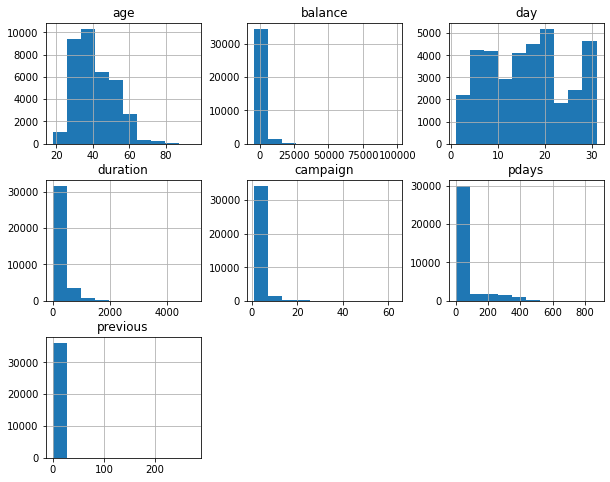

In [4]:
plt.rcParams["figure.figsize"] = [10, 8]
print("HISTOGRAMAS PARA TRAIN")
x_train.hist()
plt.show()

Histogramas de las etiquetas


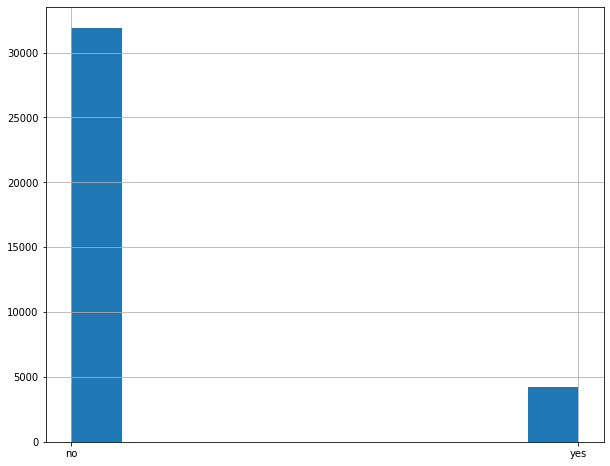


Número de valores por clase: 
 no     31917
yes     4251
Name: y, dtype: int64
Porcentajes de 'yes':  13.318920951217219 %


In [5]:
print("Histogramas de las etiquetas")
y_train.hist()
plt.show()

h = y_train.value_counts()

print("\nNúmero de valores por clase: \n",h)
print("Porcentajes de 'yes': ", (h[1]/h[0])*100, "%")

In [6]:
print(x_train.count())

age          36168
job          36168
marital      36168
education    36168
default      36168
balance      36168
housing      36168
loan         36168
contact      36168
day          36168
month        36168
duration     36168
campaign     36168
pdays        36168
previous     36168
poutcome     36168
dtype: int64


**(3)** Viendo los histogramas del conjunto de train vemos como la distribución de los datos no es uniforme en todas las características. Podemos ver también que los ejemplos para cada característica son los mismos, por lo que hay balanceo en ese sentido. En cuanto a las clases (yes o no) hay un grandísimo desbalanceo a favor de 'no', teniendo un porcentaje de tan solo 13% para la clase 'yes'.

BOXPLOTS



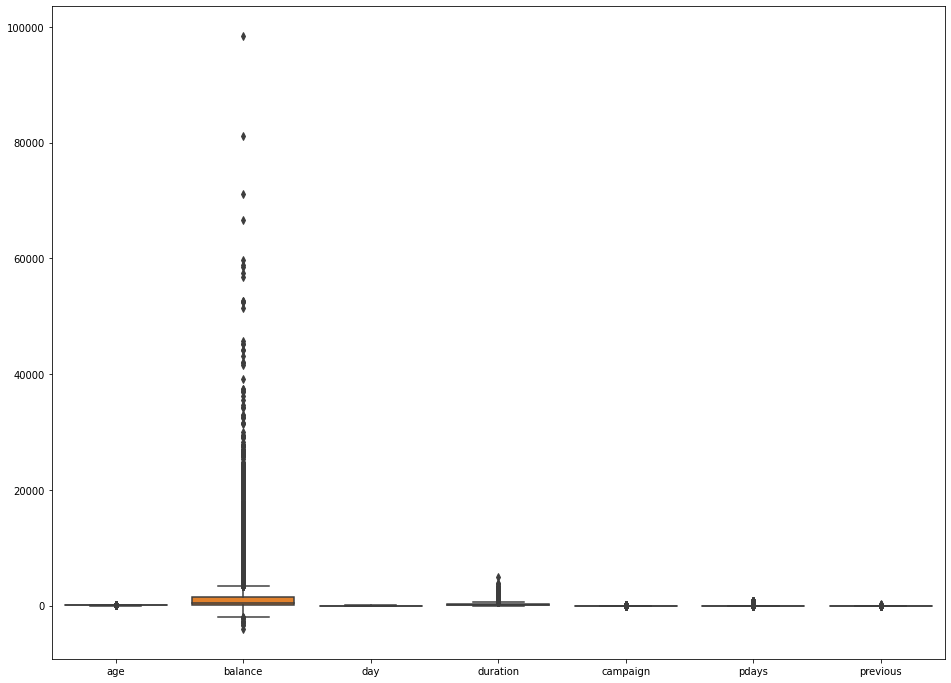

,age,balance,day,duration,campaign,pdays,previous
count,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000
mean,40.963144,1354.142059,15.784837,258.425791,2.766783,40.228738,0.579822
std,10.631362,2961.344216,8.337451,257.929559,3.111382,100.290166,2.381052
min,18.000000,-4057.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,73.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,451.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1430.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,98417.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [7]:
plt.rcParams["figure.figsize"] = [16, 12]
print("BOXPLOTS\n")
sns.boxplot(data=x_train)
plt.show()

x_train.describe()

**(4)** El gráfico de BoxPlot es bastante útil a la hora de visualizar datos numéricos por medio de sus cuartiles. De esta forma, los valores de la población están dentro de la caja. Los puntos individuales fuera de ella indican outliers (no tienen por qué serlo), datos que están muy distantes del resto de observaciones, por lo que se sugiere que un outlier está fuera de lo que queremos estudiar, no nos aporta información. Además si nos fijamos en la tabla de datos, podemos ver como algunas columnas se ven claramente afectadas en la media, mientras que la mediana no es tan afectada por los outliers.

Podemos ver pues, que nuestros datos tienen claros outliers, los cuales serán manejados más adelante en el preprocesado de datos. Para ello utilizaremos el Local Outlier Factor. En principio iba a utilizar el z-score cuya métrica nos dice como de lejos está un punto de la media, es una medida de cuantas desviaciones estándar por debajo o por encima de la media de la población tiene una puntuación. Una puntuación en z-score de 3 significa que está en el rango de +3 o -3 desviaciones estándar (a la izquerda o derecha más alejada de la distribución). Los valores que sobrepasen este umbral normalmente son considerados outliers. En nuestro caso, nuestros datos no están uniformemente distribuidos, por lo que puede ocurrir que el umbral nos corte ciertos outliers, pero no todos.

BOXPLOT EDAD



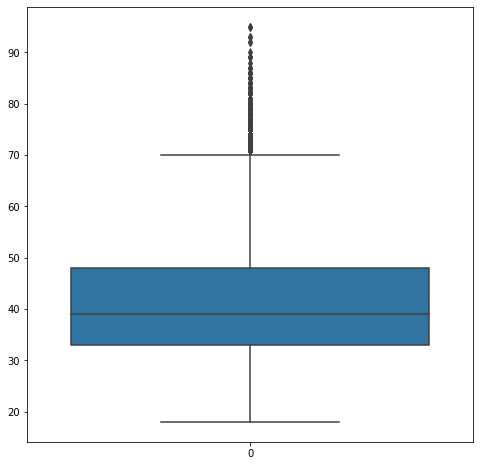


Outliers:  387

Cantidad de ejemplos en personas 'edad':  36168

Porcentaje de outliers frente al total:  1.0700066357000664


In [8]:
plt.rcParams["figure.figsize"] = [8, 8]
print("BOXPLOT EDAD\n")
sns.boxplot(data=x_train.age)
plt.show()

g_than70 = x_train.age[x_train.age > 70].value_counts().sum()
total_age = x_train.age.size

print("\nOutliers: ", g_than70)
print("\nCantidad de ejemplos en personas 'edad': ", total_age)
print("\nPorcentaje de outliers frente al total: ", (g_than70/total_age)*100)

**(5)** En el caso de la edad vemos que hay un porcentaje de outliers de apenas el 1% de la población total, por lo que eliminarlos no es una pérdida y le estamos haciendo un favor al modelo. Estos se encuentran en el rango de edad de 70 a 90+ años. Claramente podría haber ejemplos fuera de la muestra de personas en este rango, pero si el conjunto de datos solo tiene unos pocos ejemplos dentro de este intervalo, el modelo apenas podría aprender nada y no supondría un aporte de información.

Columnas con algún valor 'unknown':
---- job ---
---- education ---
---- contact ---
---- poutcome ---



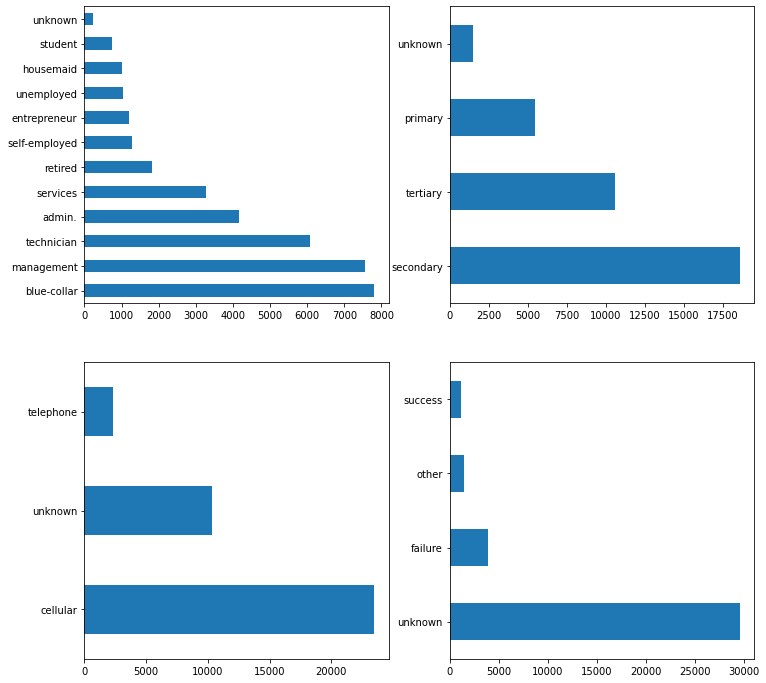

In [9]:
# Vemos que columnas contienen unknown
print("Columnas con algún valor 'unknown':")
for c in x_train.columns[x_train.isin(['unknown']).any()]:
    print("---- %s ---" % c)
print()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

x_train['job'].value_counts().plot(kind='barh', ax=axes[0,0])
x_train['education'].value_counts().plot(kind='barh', ax=axes[0,1])
x_train['contact'].value_counts().plot(kind='barh', ax=axes[1,0])
x_train['poutcome'].value_counts().plot(kind='barh', ax=axes[1,1])
plt.show()

**(6)** Creamos gráficas para aquellas columnas que contengan valores desconocidos. Con esta visualización vemos que columnas son unknown. En el caso de poutcome, podemos ver que la gran mayoría de valores que toma esta columna son desconocidos y por tanto podríamos pensar que irrelevantes. Pese a ello, unknown es distinto de nulo, podrían a pesar de todo aportar algo de información ya que dependiendo de este valor la etiqueta puede cambiar.

In [10]:
def sin_transformer(period):
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

**(7)** Hemos definido esta función, la cual está sacada del siguiente enlace visitado -> [transformaciones para datos cíclicos](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/). La usaremos más tarde para transformar los meses. Como parámetro le pasamos el período del ciclo, en nuestro caso serán meses, es decir, período 12. Esto lo realizamos ya que es lógico que al tener información cíclica haya conexiones más fuertes entre datos más cercanos entre sí (como Enero y Febrero o Febrero y Marzo). Esta función utiliza un FunctionTransformer que se encarga de reenviar sus argumentos a una función u objeto de función definido por el usuario, después devuelve el resultado de esta función.

In [11]:
# Función para preprocesamiento de datos
def preProcData(c_datos, labels):
  ordinal_encoder = OrdinalEncoder()

  c_datos = c_datos.join(labels)

  # Transformamos variables textuales a numéricas
  c_datos = pd.concat([c_datos, pd.get_dummies(c_datos['job'], prefix='job')],axis=1)
  c_datos.drop(['job'],axis=1, inplace=True)

  c_datos = pd.concat([c_datos, pd.get_dummies(c_datos['education'], prefix='education')],axis=1)
  c_datos.drop(['education'],axis=1, inplace=True)

  c_datos = pd.concat([c_datos, pd.get_dummies(c_datos['contact'], prefix='contact')],axis=1)
  c_datos.drop(['contact'],axis=1, inplace=True)

  c_datos = pd.concat([c_datos, pd.get_dummies(c_datos['marital'], prefix='marital')],axis=1)
  c_datos.drop(['marital'],axis=1, inplace=True)

  c_datos = pd.concat([c_datos, pd.get_dummies(c_datos['poutcome'], prefix='poutcome')],axis=1)
  c_datos.drop(['poutcome'],axis=1, inplace=True)

  c_datos[['month']] = ordinal_encoder.fit_transform(c_datos[['month']])

  # Transformamos variables cíclicas
  c_datos[['month']] = sin_transformer(12).fit_transform(c_datos[['month']])
  c_datos[['day']] = sin_transformer(31).fit_transform(c_datos[['day']])

  # Eliminamos columna con información no buena para el aprendizaje 
  c_datos = c_datos.drop(columns = ['duration'])

  # Tranformamos variables binarias a 1 o -1
  c_datos = c_datos.replace(['yes'],1)
  c_datos = c_datos.replace(['no'],-1)

  # Quitamos outliers
  LOF = LocalOutlierFactor(contamination=0.02)
  outliers = LOF.fit_predict(c_datos)

  # Eliminamos los datos que son considerados outliers (-1)
  c_datos = c_datos[outliers != -1]

  # Borramos datos nulos si los hay
  c_datos.dropna(inplace=True)

  c_labels = c_datos.loc[:,'y']
  c_datos = c_datos.loc[:, c_datos.columns != 'y']

  print("Características antes de variancethreshold: ", c_datos.shape[1])
  # Los datos cuya variabilidad sea nula (0) serán eliminados
  selector = VarianceThreshold(threshold=0)
  c_datos = selector.fit_transform(c_datos)
  print("Características después de variancethreshold: ", c_datos.shape[1])

  # Estandarizamos los datos
  scaler = StandardScaler()
  c_datos = scaler.fit_transform(c_datos)

  return c_datos, c_labels

print("Tamaño de x_train antes de preprocesado: ", x_train.shape[0])
before_outliers = x_train.shape[0]
x_train, y_train = preProcData(x_train, y_train)
print("Tamaño de x_train después de preprocesado: ", x_train.shape[0])
after_outliers = x_train.shape[0]

x_test, y_test = preProcData(x_test, y_test)

print("Porcentaje de valores outliers eliminados: ", (1-(after_outliers/before_outliers))*100, "%")

Tamaño de x_train antes de preprocesado:  36168
Características antes de variancethreshold:  36
Características después de variancethreshold:  36
Tamaño de x_train después de preprocesado:  35444
Características antes de variancethreshold:  36
Características después de variancethreshold:  36
Porcentaje de valores outliers eliminados:  2.0017695200176933 %


#Preprocesado de datos
**(8)** Definimos función para el preprocesamiento de datos. En primer lugar utilizamos la función de "get_dummies" de pandas la cual nos transforma cadenas de caracteres en una codificación numérica. De esta forma podemos transformar las variables que representen categorías en dígitos.

En el caso de las clases que tengan valores 'unknown' decido dejarlos y transformarlos igualmente. Podría parecer que valores desconocidos son irrelevantes, pero no representan exactamente lo mismo que valores nulos o NaN, por lo que pueden ayudar en el aprendizaje.

En caso de ser nulos podriamos sustituir con la media los valores NaN, que tiene el beneficio de que no cambia la media de la muestra, pero en nuestro caso como hemos visto anteriormente, tenemos outliers, por lo que la media puede estar afectada en gran medida por estos. Por ello en vez de cambiar valores nulos por la media, podríamos optar por la mediana, que como hemos visto anteriormente en el análisis de datos, no se ve tan afectada. Igualmente añadir información por nuestra cuenta puede distorsionar la generalidad de nuestro modelo. 

La categoría 'duration' representa la duración del último contacto. Este atributo afecta claramente al output, si la duración=0 el output es un 'no'. Por ello, al no saber la duración antes de la llamada este input no debería ser incluido (si además la duración es de 0 ya sabemos la respuesta).

De igual manera transformamos las variables binarias que aparezcan en forma de texto (en nuestro caso "yes" y "no") a números. Elegimos la representación binaria de 1 y -1, pero podría utilizarse cualquier otra codificación.

Como explicamos anteriormente, vamos a basarnos en la puntuación que nos proporcione la función Local Outlier Factor para filtrar outliers.

Lo siguiente que hace la función es estandarizar los datos ya que los algoritmos de aprendizaje no funcionan muy bien cuando hay una diferencia muy notable entre datos. Para ello utilizamos la herramienta de escalado StandardScaler. Estandarizar las características alrededor del centro y 0 con una desviación estándar de 1 es importante cuando comparamos medidas que tienen diferentes unidades. Las variables que se miden en diferentes escalas no contribuyen por igual al análisis y pueden terminar creando un sesgo y en nuestro caso es así.

Referente a la variabilidad de las características, el coeficiente de variación toma valores entre 0 y 1. Si el coeficiente es próximo al 0, significa que existe poca variabilidad en los datos. Nosotros vamos a indicar que nuestro límite es 0, aunque VarianceThreshold ya lo implementa por defecto. Esto lo hago de esta manera, ya que la varianza depende de la escala de los datos, y normalmente no es un buen aproximador de como de buena es una característica (además nuestros datos se mueven en distintas escalas). Aunque esto sea así, una característica con 0 variabilidad sí que podríamos decir con exactitud que no aporta nada, pues su valor es igual para todas las observaciones y por tanto no añade información. Por ello nuestro límite será 0.

La función de procesamiento de etiquetas simplemente cambia los 'yes' por 1 y los 'no' por 0.

**(9)** Referente al tema de outliers he optado por utilizar Local Outlier Factor, el cuál funciona bien para conjuntos de datos con pocas características (en nuestro caso 36, son pocas en comparación a casos reales).

La puntuación de anomalías de Local Outlier Factor mide la desviación local de la densidad de una muestra dada con respecto a sus vecinos. A más aislado esté el punto mayor puntuación tendrá. La localidad se da respecto a los k vecinos mas cercanos, cuya distancia se usa para estimar la densidad local.

La cantidad de contaminación del conjunto de datos es la proporción de outliers en el conjunto, se utiliza como umbral para las puntuaciones y esta suele ir entre 0 y 0.5. En nuestro caso definiremos 0.02 para un 2% de datos de outliers como mucho, ya que no deberíamos eliminar más de un 5% del total de datos.

In [ ]:
# Hacemos la selección de hiperparámetros usando cross validation para LR
def featureSelectionLR(x_train,y_train,folds):
    parameters = [{'penalty':['l1','l2'],'C':[1,10,100,1000,10000],'solver':['liblinear'],'class_weight':[{1:0.9, -1:0.1}]}]
    logic_regression = linear_model.LogisticRegression(max_iter=1000)
    g_ = GridSearchCV(logic_regression, parameters, cv=folds, scoring='recall')
    g_.fit(x_train,y_train)
    print("Logistic-regression:\n----------------")
    print("Hiperparámetros: ", g_.best_params_)
    print("Accuracy: ", metrics.accuracy_score(y_train, g_.best_estimator_.predict(x_train)))
    print("Recall: ", metrics.recall_score(y_train, g_.best_estimator_.predict(x_train), pos_label=1))
    print("F1: ", metrics.f1_score(y_train, g_.best_estimator_.predict(x_train), pos_label=1))
    return g_

# Hacemos la selección de hiperparámetros usando cross validation para PLA
def featureSelectionPLA(x_train,y_train,folds):
    parameters = [{'penalty':['l1','l2'],'alpha':[0.1,0.01,0.001,0.0001,0.00001],'class_weight':[{1:0.9, -1:0.1}]}]
    perceptron = linear_model.Perceptron(early_stopping=True,n_iter_no_change=1,max_iter=1000)
    g_ = GridSearchCV(perceptron, parameters, cv=folds, scoring='recall')
    g_.fit(x_train,y_train)
    print("PLA:\n----------------")
    print("Hiperparámetros: ", g_.best_params_)
    print("Accuracy: ", metrics.accuracy_score(y_train, g_.best_estimator_.predict(x_train)))
    print("Recall: ", metrics.recall_score(y_train, g_.best_estimator_.predict(x_train), pos_label=1))
    print("F1: ", metrics.f1_score(y_train, g_.best_estimator_.predict(x_train), pos_label=1))
    return g_

# Hacemos la selección de hiperparámetros usando cross validation para dummy
def featureSelectionDummy(x_train,y_train,folds):
    parameters = [{'strategy':['constant'], 'constant':[1]}]
    dummy = DummyClassifier()
    g_ = GridSearchCV(dummy, parameters, cv=folds, scoring='recall')
    g_.fit(x_train,y_train)
    print("PLA:\n----------------")
    print("Hiperparámetros: ", g_.best_params_)
    print("Accuracy: ", metrics.accuracy_score(y_train, g_.best_estimator_.predict(x_train)))
    print("Recall: ", metrics.recall_score(y_train, g_.best_estimator_.predict(x_train), pos_label=1))
    print("F1: ", metrics.f1_score(y_train, g_.best_estimator_.predict(x_train), pos_label=1))
    return g_

# DESCOMENTAR PARA PROBAR DIFERENTES K PARA CV
#for i in range(5,11):
#  print("\n----CROSS-VALIDATION PARA ", i, " PARTICIONES----")
#  best_model_LR = featureSelectionLR(x_train,y_train,i)
#  best_model_PLA = featureSelectionPLA(x_train,y_train,i)

best_model_LR = featureSelectionLR(x_train,y_train,5)
best_model_PLA = featureSelectionPLA(x_train,y_train,5)
best_model_Dummy = featureSelectionDummy(x_train,y_train,5)

# Hacemos test para LR
def LogisticRegression(x_train, y_train, x_test, y_test, best_model):
  g = linear_model.LogisticRegression(**best_model.best_params_).fit(x_train, y_train)
  predictions = g.predict(x_test)
  score = g.score(x_test,y_test)
  print("E_test:", 1-score)
  print("Recall: ", metrics.recall_score(y_test, g.predict(x_test), pos_label=1))
  print("F1: ", metrics.f1_score(y_test, g.predict(x_test), pos_label=1))
  return g, predictions, score

print("\n\n----------- RESULTADOS CONJUNTO TEST -----------\n\n")

model_LR, predictions_LR, etest = LogisticRegression(x_train, y_train, x_test, y_test, best_model_LR)

#Formulación hipótesis y entrenamiento
**(10)** Definimos dos funciones de selección de parámetros usando cross-validation para regresión logística y para Percetron con early-stopping. Hemos elegido los modelos lineales de PLA (sklearn no incluye pocket) y de regresión logística para nuestro problema de clasificación. Escogeremos el modelo que mejor resultados dé dado un criterio de evaluación. La manera en que este modelo será seleccionado será mediante la aplicación distintos tipos de regularizadores y distintas cantidades de regularización. 

La mejor combinación de parámetros darán dos modelos (uno de regresión logística y otro de Perceptron + earlystoppin). El que mejor resultados arroje será el elegido.

Como añadido hemos añadido un clasificador Dummy, el cual no tiene en cuenta los datos de entrada para absolutamente nada. Le pasamos por parámetros la estrategia, en nuestro caso 'constant', lo cual hace que siempre prediga una clase constante que nosotros le pasaremos por parámetro. Es un clasificador sin criterio alguno.

Como parámetros estáticos hemos seleccionado que nuestro modelo debe tener earlystopping en el momento de aprendizaje (PLA). Este parámetro indica que tras unas cuantas épocas sin mejorar el algoritmo deberá parar. El número de épocas viene determinado por n_iter_no_change. Estos dos últimos son sobre todo por cuestiones de tiempo, ya que el algoritmo podía tardar muchos minutos y arrojar una solución igual de buena que con earlystopping (de hecho tras varias ejecuciones, es así, de ahí la elección de épocas = 1).

Vamos a utilizar cross-validation, el cual nos dará una estimación sin sesgo del $E_{out}$. La potencia de este tipo de validación es poder usar más muestras para el entrenamiento siendo estas independientes de las particiones de validación. Consiste en realizar la media de las medidas obtenidas en diferentes particiones. En nuestro caso utilizaremos 5-fold cross validation, creando como el propio nombre indica 5 particiones de los datos disjuntas. Esta variante es más rápida que simplemente usar cross-validation. Utilizaremos 5 particiones en nuestro caso (lo común son 10, pero depende del problema). En mi caso he probado varios números de particiones con resultados muy similares (el bucle for que comprueba resultado está comentado por ahorro de tiempo de ejecución). 

Dentro de la función GridSearchCV que realiza el cross-validation para la estimación de los hiperparámetros se encuentra el estimador (logistic-resgression o PLA), los parámetros a estimar, número de folds para cross validaton (por defecto se aplica Stratified, lo cuál indica que se preseva en cada fold el porcentaje de ejemplos por clase), y el parámetro scoring, al cual debemos pasarle el tipo de métrica que decidirá que modelo es más prometedor según nuestros intereses.

**(11)** A estos modelos les hemos aplicado distintos tipos de regularizadores y distintas cantidades de regularización. Los regularizadores usados se especifican en los parámetros de 'penalty' y son:
* Regularizador Lasso (l1): este tipo de regularizacin minimiza la siguiente expresión:

  $min_{w,c}\frac{1}{2}w^Tw+C\sum_{i=1}^{N}log(exp(-y_i(X_i^Tw+c))+1).$   
  
  Esta es efectiva cuando los atributos de entrada sean irrelevantes o así lo sospechemos, pues algunos coeficientes pueden acabar valiendo 0. De esta forma tendremos solo algunos atributos relevantes, nuestra complejidad será mejor y tendremos una mejor generalización. Funciona mejor cuando no hay demasiada relación entre atributos.
* Regularizador Ridge (l2): se minimiza la siguiente expresión:

  $min_{w,c}||w||_1+C\sum_{i=1}^{N}log(exp(-y_i(X_i^Tw+c))+1).$ 

  Esta se suele utilizar cuando, al contrario que en l1 (lasso), sospechamos que los atributos si tienen conexiones más fuertes entre ellos. Ridge se encarga de minimizar los coeficientes.

En nuestro caso el regularizador más apto podría ser l1 debido a que los atributos de nuestro problema parecen más dispersos entre sí, sin tener una fuerte correlación entre ellos. Ejemplos de atributos sin fuerte relación entre ellos podrían ser la edad del cliente, su educación, el número de días desde la última vez que el cliente fue contactado etc.

Dentro de regresión logística podemos ver en los parámetros que utilizamos el algoritmo de optimización 'liblinear'. Mis motivos para ello son que puede utilizar los dos tipos de regularizadores, a diferencia de Newton, y que el hecho de que no pueda aprender un problema multiclase no nos afecta (nuestro caso es un problema binario). Podemos observar tambien algunos parámetros como $C$ o $\lambda$ (alpha). A mayor sea $C$ menor será la restricción impuesta por el regularizador, en cambio $\lambda$ al ser la inversa de $C$, a mayor tamaño mayor cantidad de regularización. Hay otro parámetros como multi-class, pero por defecto se asigna a 'auto', lo cual hace que se adecue al problema binario.
También tenemos el parámetro 'tol' el cual hace referencia a la tolerancia como criterio de parada, por defecto está asignada a 1e-4.

Además hemos añadido como último parámetro un peso de importancia para las clases. Hemos visto al principio que existe un claro desbalanceo de clases, siendo la mayoría de ejemplos clasificados con 'no' mientras solo unos pocos estaban clasificados con 'si'. Para solucionar esto e intentar que nuestro modelo no se ajuste únicamente con la clase mayoritaria hemos introducido unos pesos que le dan un porcentaje de importancia mayor a 'si'. Además, es la clase que más nos interesa desde el punto de vista de la empresa, nos interesa saber qué clientes sí van a hacer un depósito en el banco, los 'no' son mucho más irrelevantes.

Por ello introduzco mucho más peso a la clase 1 ('yes') que a la clase -1, pero sin ser demasiado exagerado, ya que a partir de 90% de peso quizá estoy adecuando demasiado mis preferencias dentro del aprendizaje. Con valores inferiores al 80% no se observa demasiado cambio, debido al bajo número de ejemplos que presenta la clase 1.

#Validación
**(12)** Utilizamos la función GridSearchCV la cuál dado unos parámetros se encarga mediante una búsqueda exhaustiva de especificar la mejor combinación de los mismos para el modelo final. Hace uso de cross-validation para seleccionar los mejores parámetros para el modelo. Usamos como métrica de puntuación de parámetros scoring='recall' la cuál va a indicar a GridSearchCV que selecione el modelo que mejor resultados dé en esa métrica. Pese a ello, la elección se guiará no solo por recall. Un algoritmo prácticamente aleatorio podría darnos resultados muy buenos en recall, valoraremos el conjunto de métricas (sobre todo f1-score, recall y accuracy)

'Recall' es el ratio de positivos verdaderos / (positivos verdaderos + falsos negativos). Esta métrica viene a darnos el porcentaje de una cierta clase correctamente identificada (lo cuál nos interesa en este problema, en concreto con la clase 'yes').

'F1' combina las métricas precision y recall del clasificador utilizando su media armónica. F1 = (precision * recall) / (precision + recall). Se suele utilizar para medir la calidad de los clasificadores, si uno da mejores resultados en recall, pero el otro es mejor en precision, el f1-score nos ayudará a comprobar cuál es de mejor calidad.

Una vez hecha la selección de modelos mostramos por pantalla los resultados de las métricas del mejor modelo de Regresión Logística y de PLA con earlystopping. También mostramos los parámetros que mejor resultado han dado en la selección.

#Discusión resultados
**(13)** Podemos observar que en términos de precisión y f1 regresión logística nos da un mejor rendimiento que PLA. En términos generales, regresión logística nos da una mejores métricas en todo. PLA es cierto que presenta un recall de 90%, pese a ello como habíamos explicado antes, no nos podemos fijar en una única métrica, pues hay clasificadores totalmente aleatorios que podrían arrojar resultados similares. Por ello debemos fijarnos en las métricas del clasificador dummy, donde nos da de recall un 100%. Claremente este algoritmo sin criterio no es bueno, por ello hay que tener en cuenta varias métricas.

Nos fijamos pues en que la puntuación de f1 es mejor en regresión logística, por lo que optamos por este modelo. Además, la puntuación recall es bastante buena a pesar de ser inferior que en PLA.

In [ ]:
eout = 1-etest + mt.sqrt(mt.log(2/0.05)/(2*x_test.shape[0]))
print("Estimación Eout: ", eout)

**(14)** Sabiendo que $E_{test}$ es una buena cota para $E_{out}$ podemos asegurar con seguridad que el error fuera de la muestra será siempre:
  
  * $E_{out}(g)\leq E_{test}(g) + \sqrt{\frac{1}{2N}ln \frac{2}{α}}$

Dado esta fórmula calculamos la cota para el error fuera de la muestra. En este caso la variable $α=0.05$ indica que la cota es esa para una confianza del 95%.

In [ ]:
def roc_curve(m_lr,x_v,y_v):
  plt.figure(figsize=(8,8)).clf()
  p_lr = m_lr.predict_proba(x_v)[:,-1]
  fpr, tpr, _ = metrics.roc_curve(y_v, p_lr)
  auc = metrics.roc_auc_score(y_v, p_lr)
  plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curves',size=10)

  plt.legend(loc=0)
  plt.show()

roc_curve(model_LR, x_test, y_test)

**(15)** Otra posible interpretación de la calidad de los modelos es la de la visualización de una curva ROC. La curva ROC mide la calidad de nuestro modelo respecto a los falsos positivos y a los verdaderos positivos. Cuanto más se acerque la curva a la esquina superior izquierda de mejor calidad es nuestro modelo. Vemos que LR tiene un área debajo de la curva (AUC = area under the curve) de más de 70%.

In [ ]:
def createLearningCurves(x_train, y_train, model):
  X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=12345)

  ein = []
  eout = []
  N = []
  alpha = 0.001 # porcentaje del total (a más bajo menor es el tamaño de cada muestra)
  j = round(X_train.shape[0] * alpha)

  for i in range(X_train.shape[0]):
    model.fit(X_train[i:j],Y_train[i:j])
    predictions = model.predict(X_train[i:j])
    score = metrics.recall_score(Y_train[i:j], predictions)
    ein.append(1-score)

    predictions = model.predict(X_val[i:j])
    score = metrics.recall_score(Y_val[i:j], predictions)
    eout.append(1-score)
    N.append(j)

    alpha += 0.001
    i = j + 1

    if i >= X_train.shape[0]:
      break

    if (j + round(X_train.shape[0] * alpha)) < X_train.shape[0]:
      j = j + round(X_train.shape[0] * alpha)
    else:
      j = X_train.shape[0]

  return ein, eout, N

einLR, eoutLR, N = createLearningCurves(x_train, y_train, model_LR)

In [ ]:
def learning_curves(ein, eout, N):
  plt.figure(figsize=(7,7))
  x1 = N
  y1 = ein
  x2 = N
  y2 = eout

  plt.plot(x1, y1, c = 'b', label = "E_in")
  plt.plot(x2, y2, c = 'r', label = "E_test")
  plt.xlabel("Number of data points, N")
  plt.ylabel("Error")
  plt.legend()

  plt.show()

print("---- LEARNING CURVES LR ----\n")
learning_curves(einLR, eoutLR, N)

**(16)** Analizando las curvas de aprendizaje de nuestro modelo de LR podemos observar como la curva del error dentro de la muestra (dentro del training set) aumenta drásticamente al principio, después de un pequeño pozo vuelve a subir y se estabiliza (el error ya no sube). Con validación ocurre que comienza teniendo un error alto y después de un salto empieza a disminuir hasta estabilizarse por encima del error dentro de la muestra. Estas curvas podrían interpretarse con un modelo que tiene capacidad y potencial de aprender, pese a ello el error sigue siendo quizá demasiado alto, por lo que es posible que la cantidad de datos sea insuficiente o el conjunto de datos no sea del todo representativo del problema que queremos resolver. De todas maneras, las curvas indican un proceso de aprendizaje.

Vemos como ambas curvas se siguen, y es que si N es suficientemente grande es muy probable que sea cercano al error out of sample (debido a la desigualdad de Hoeffding). 

  * $P[|E_{in} - E_{out}| > ε] \leq 2e^{-2ε^2N}$

#Empresa
**(17)** Si fuese una persona dentro de una empresa a la que le han encargado realizar este ajuste sin distinción entre training y test debería tener varias cosas en cuenta.

Tenemos que saber lo que implica usar un conjunto de validación, y es que el conjunto de validación es casi idéntico al conjunto de test. Retiramos un subconjunto de los datos que no es usado en training y luego lo utilizamos para testar los resultados y estimar $E_{out}$. A pesar de que este conjunto no se usa en el training, sí que influye en cierta medida en el proceso de entrenamiento, pero lo hace de manera tan benigna que Eout apenas se ve afectado, por lo que es una buena manera de estimar $E_{out}$.

Pese a ello, también hay que tener en cuenta el tamaño del conjunto de validación. Como ya comentamos en la división de datos si el tamaño del conjunto training es demasiado pequeño (conjunto de validación muy grande), nuestra hipótesis candidata será peor pues tiene menos datos para entrenarse. Por el contrario, si el tamaño del conjunto validación es muy pequeño, nuestra varianza se disparará.

Por ello estimar un tamaño adecuado es crucial para la buena selección de nuestro modelo.

Otra cosa a tener en cuenta es no usar los datos de validación/test para absolutamente nada. Si los usasemos para el análisis cabría la posibilidad de estar guiando nuestras decisiones para adaptar el modelo lo mejor posible a esos datos, pero, ¿cuando lleguen el resto de muestras?. Nuestro modelo debe saber generalizar, no podemos adaptarlo a una muestra concreta. Mucho menos deberíamos validar con los mismos datos que entrenamos, estaríamos estimando un error muy optimista, lo cual no será ni mucho menos preciso a la hora de usarlo fuera de la muestra de entrenamiento. 

El $E_{out}$ dado debería ser una cota de este, garantizando que nunca superará este umbral. Por ello, si calculamos $E_{test}$ podríamos tener también una estimación realista del error fuera de muestra, como hemos hecho antes al estimarlo en apartados anteriores.